# 3. Transfer Learning Models

## 3.1 Imports

In [ ]:
from google.colab import files, drive
import matplotlib.pyplot as plt
import sys
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Flatten, Dense
import pickle, dill

## 3.2 Initialization

In [ ]:
#path to saved resources
saved_resources_path = '/content/gdrive/MyDrive/Capstone3/SavedResources'

#path to src folder
src_path = '/content/gdrive/MyDrive/Capstone3/src'

#mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#add the src folder to the search path so that modules in the src folder can be imported
sys.path.append(src_path)
import DataSetup
import BuildModels

The **DataSetup.py** script contains functions that are useful for preparing the dataset. This includes setting up the folder structure, performing the train/test split, and setting up the train and validation sets from the image directories. The **BuildModels.py** script contains functions to prepare the architecture for each model, compile and train the models, and plot model performance on training and validation sets.

In [ ]:
#load saved constants
with open(os.path.join(saved_resources_path, 'constants_dict.pkl' ), 'rb') as handle:
    constants_dict = pickle.load(handle)

constants_dict

{'CLASS_SIZE': 5000, 'IMAGE_SIZE': (768, 768), 'K': 5, 'RANDOM_SEED': 42}

In [ ]:
#set batch size
BATCH_SIZE = 32

In [ ]:
#load the mappings of image class to folder location for the raw dataset
with open(os.path.join(saved_resources_path, 'dict_original_image_paths.pkl' ), 'rb') as handle:
    dict_image_paths = pickle.load(handle)

dict_image_paths

{'colon_aca': 'lung_colon_image_set/colon_image_sets/colon_aca/',
 'colon_normal': 'lung_colon_image_set/colon_image_sets/colon_n/',
 'lung_aca': 'lung_colon_image_set/lung_image_sets/lung_aca/',
 'lung_normal': 'lung_colon_image_set/lung_image_sets/lung_n/',
 'lung_scc': 'lung_colon_image_set/lung_image_sets/lung_scc/'}

## 3.3 Load and Prepare Data

### 3.3.1 Upload API key to connect to kaggle

In [ ]:
#upload the API key (kaggle.json)
_ = files.upload()

Saving kaggle.json to kaggle.json


### 3.3.2 Download and Unzip the Dataset

In [ ]:
###download and unzip the lung and colon cancer image dataset using the saved function "dataset_setup"
with open(os.path.join(saved_resources_path,'dataset_setup_function.pkl'), 'rb') as file_in:
    dataset_setup = dill.loads(dill.load(file_in))

dataset_setup()

100% 1.76G/1.76G [00:14<00:00, 151MB/s]
100% 1.76G/1.76G [00:14<00:00, 131MB/s]


### 3.3.3 Train/Test Split

**Setup train/test folders**

In [ ]:
###set up the folder structure for the train/test data using the saved function "folder_setup"

#image classes
image_classes = dict_image_paths.keys()

#function returns the folder paths for each image class in the train and test sets
train_test_path_dict = DataSetup.folder_setup(image_classes)

train_test_path_dict

{'test': {'data/test/colon_aca',
  'data/test/colon_normal',
  'data/test/lung_aca',
  'data/test/lung_normal',
  'data/test/lung_scc'},
 'train': {'data/train/colon_aca',
  'data/train/colon_normal',
  'data/train/lung_aca',
  'data/train/lung_normal',
  'data/train/lung_scc'}}

**Split the data into train/test sets**

In [ ]:
### split the data into train and test sets
DataSetup.train_test_split(saved_resources_path)

In [ ]:
##Ensure that there are no overlapping images in the train and test sets
##and that the train/test set sizes are correct
train_test_folders = ['data/train', 'data/test']

for img_class, path in dict_image_paths.items():
    train_path = os.path.join(train_test_folders[0],img_class)
    test_path = os.path.join(train_test_folders[1],img_class)

    train_set = set(os.listdir(train_path))
    test_set = set(os.listdir(test_path))

    #ensure no overlapping images
    assert len(train_set.intersection(test_set)) == 0

    #ensure the training and test set sizes are correct
    assert len(train_set) == constants_dict['CLASS_SIZE'] * 0.9
    assert len(test_set) ==  constants_dict['CLASS_SIZE'] * 0.1

## 3.4 Build Models

### 3.4.1 ResNet50 Transfer Learning Model

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###prepare the architecture for the resnet50 transfer learning model

#input shape
input_shape = (constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes 
K = constants_dict['K']

#build the model
base_model = BuildModels.build_resnet50_base(input_shape)
model_head = BuildModels.build_custom_head(base_model, K)
resnet50_model = BuildModels.build_final_model(base_model, model_head)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

94781440/94765736 [==============================] - 1s 0us/step
Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
###compile and fit the resnet50 model
results = BuildModels.compile_fit_model(resnet50_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 130s 183ms/step - loss: 2.5672 - accuracy: 0.9499 - val_loss: 0.3526 - val_accuracy: 0.9867
Epoch 2/100
633/633 [==============================] - 114s 180ms/step - loss: 0.3226 - accuracy: 0.9853 - val_loss: 0.2829 - val_accuracy: 0.9858
Epoch 3/100
633/633 [==============================] - 114s 179ms/step - loss: 0.0541 - accuracy: 0.9950 - val_loss: 0.2842 - val_accuracy: 0.9849
Epoch 4/100
633/633 [==============================] - 114s 179ms/step - loss: 0.1146 - accuracy: 0.9929 - val_loss: 0.4203 - val_accuracy: 0.9787
Epoch 5/100
633/633 [==============================] - 114s 179ms/step - loss: 0.0767 - accuracy: 0.9943 - val_loss: 0.4572 - val_accuracy: 0.9844
Epoch 6/100
633/633 [==============================] - 114s 179ms/step - loss: 0.0618 - accuracy: 0.9958 - val_loss: 0.3336 - val_accuracy: 0.9858
Epoch 7/100
633/633 [==============================] - 114s 180ms/step - loss: 0.0901 - accuracy: 0.9934 - val_loss: 0

**Plot loss and accuracy**

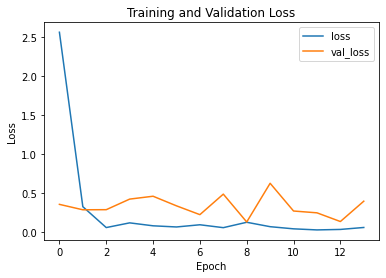

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

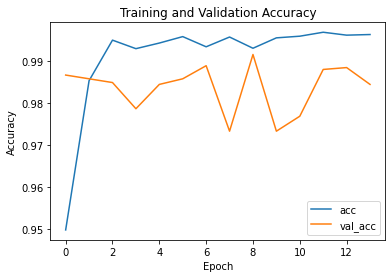

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
##Save the weights for the head (trainable portion) of the ResNet50 Model

#list to hold the weights
trainable_weights = []

#get the trainable weights
for i, layer in enumerate(resnet50_model.layers):
    if layer.trainable:
        trainable_weights.append(layer.get_weights())

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/transfer-resnet50/'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the weights
if not os.path.exists(os.path.join(filepath,'resnet50_trainable_weights.pkl')):
    with open(os.path.join(filepath,'resnet50_trainable_weights.pkl'), 'wb') as file_out:
        pickle.dump(trainable_weights, file_out, protocol=pickle.HIGHEST_PROTOCOL)

**Resnet50 Transfer Learning Model Analysis**

* A ResNet50 transfer learning model was trained because the ResNet50 architecture has been shown to be highly effective at classifying histopathology images. Pre-trained ImageNet weights were used for the non-trainable portion of the model.
* The ResNet50 model's best performance was 99.16% accuracy on the validation set. The model trained for 14 epochs meaning that the model performed best on epoch 9 (since early stopping with a patience of 5 was used). The best version of the model was saved. 
* The model's performance was very consistent, as it had a validation accuracy higher than 97% on on all 14 training epochs.

**References**
* https://www.sciencedirect.com/science/article/pii/S0933365719307110

### 3.4.2 DenseNet121 Transfer Learning Model

**Build and train the model**

In [ ]:
###get the data

#random_state
random_state = constants_dict['RANDOM_SEED']

#image_size
image_size=(constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2)

#get train and validation sets
train_data, validation_data = \
    DataSetup.training_datasets_from_directory(random_state, image_size, BATCH_SIZE)

Found 22500 files belonging to 5 classes.
Using 20250 files for training.
Found 22500 files belonging to 5 classes.
Using 2250 files for validation.


In [ ]:
###prepare the architecture for the DenseNet transfer learning model

#input shape
input_shape = (constants_dict['IMAGE_SIZE'][0]//2, constants_dict['IMAGE_SIZE'][1]//2, 3)

#number of classes 
K = constants_dict['K']

#build the model
base_model = BuildModels.build_densenet121_base(input_shape)
model_head = BuildModels.build_custom_head(base_model, K)
densenet121_model = BuildModels.build_final_model(base_model, model_head)

#set dtype policy to mixed_float16 for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
###compile and fit the DenseNet121 model
results = BuildModels.compile_fit_model(densenet121_model, train_data, validation_data)

Epoch 1/100
633/633 [==============================] - 131s 193ms/step - loss: 19.0638 - accuracy: 0.8439 - val_loss: 0.7909 - val_accuracy: 0.9364
Epoch 2/100
633/633 [==============================] - 119s 187ms/step - loss: 0.8026 - accuracy: 0.9108 - val_loss: 0.8083 - val_accuracy: 0.9071
Epoch 3/100
633/633 [==============================] - 119s 187ms/step - loss: 0.6061 - accuracy: 0.9121 - val_loss: 0.6687 - val_accuracy: 0.9316
Epoch 4/100
633/633 [==============================] - 117s 185ms/step - loss: 0.2767 - accuracy: 0.9349 - val_loss: 0.2285 - val_accuracy: 0.9502
Epoch 5/100
633/633 [==============================] - 117s 184ms/step - loss: 0.3454 - accuracy: 0.9264 - val_loss: 0.5797 - val_accuracy: 0.9298
Epoch 6/100
633/633 [==============================] - 117s 184ms/step - loss: 0.2806 - accuracy: 0.9164 - val_loss: 0.2866 - val_accuracy: 0.9449
Epoch 7/100
633/633 [==============================] - 117s 185ms/step - loss: 0.2684 - accuracy: 0.9316 - val_loss: 

**Plot loss and accuracy**

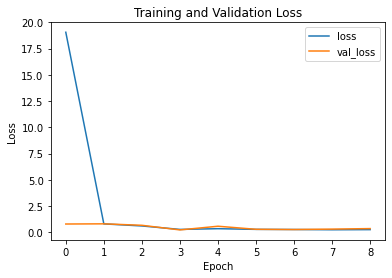

In [ ]:
#plot the loss
BuildModels.plot_loss(results)

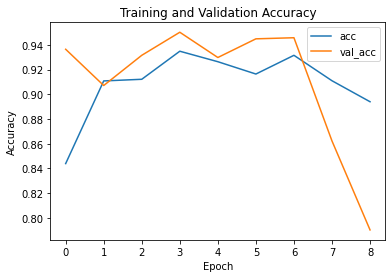

In [ ]:
#plot the accuracy
BuildModels.plot_accuracy(results)

**Save the model**

In [ ]:
##Save the weights for the head (trainable portion) of the DenseNet121 Model

#list to hold the weights
trainable_weights = []

#get the trainable weights
for i, layer in enumerate(densenet121_model.layers):
    if layer.trainable:
        trainable_weights.append(layer.get_weights())

#set the file path
filepath = '/content/gdrive/MyDrive/Capstone3/models/transfer-densenet121/'

#create the folder if it does not exist
if not os.path.isdir(filepath):
    os.mkdir(filepath)

#save the weights
if not os.path.exists(os.path.join(filepath,'densenet121_trainable_weights.pkl')):
    with open(os.path.join(filepath,'densenet121_trainable_weights.pkl'), 'wb') as file_out:
        pickle.dump(trainable_weights, file_out, protocol=pickle.HIGHEST_PROTOCOL)

**DenseNet121 Transfer Learning Model Analysis**

* A DenseNet121 transfer learning model was trained because the DenseNet121 architecture has been shown to be highly effective at classifying histopathology images. Pre-trained ImageNet weights were used for the non-trainable portion of the model.
* The DenseNet121 model did not perform as well as expected on this dataset. It appeared to overfit as performance significantly dropped off during the final epoch. Although the model did acheive a validation accuracy of 95.02% on its best iteration it still significantly underperformed the ResNet50 model. 

**References**
* https://arxiv.org/ftp/arxiv/papers/2112/2112.13553.pdf